# Understanding Hired Rides in NYC

_[Project prompt](https://docs.google.com/document/d/1VERPjEZcC1XSs4-02aM-DbkNr_yaJVbFjLJxaYQswqA/edit#)_

_This scaffolding notebook may be used to help setup your final project. It's **totally optional** whether you make use of this or not._

_If you do use this notebook, everything provided is optional as well - you may remove or add prose and code as you wish._

_Anything in italics (prose) or comments (in code) is meant to provide you with guidance. **Remove the italic lines and provided comments** before submitting the project, if you choose to use this scaffolding. We don't need the guidance when grading._

_**All code below should be consider "pseudo-code" - not functional by itself, and only a suggestion at the approach.**_

## Requirements

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project._

* Code clarity: make sure the code conforms to:
    * [ ] [PEP 8](https://peps.python.org/pep-0008/) - You might find [this resource](https://realpython.com/python-pep8/) helpful as well as [this](https://github.com/dnanhkhoa/nb_black) or [this](https://jupyterlab-code-formatter.readthedocs.io/en/latest/) tool
    * [ ] [PEP 257](https://peps.python.org/pep-0257/)
    * [ ] Break each task down into logical functions
* The following files are submitted for the project (see the project's GDoc for more details):
    * [ ] `README.md`
    * [ ] `requirements.txt`
    * [ ] `.gitignore`
    * [ ] `schema.sql`
    * [X] 6 query files (using the `.sql` extension), appropriately named for the purpose of the query
    * [x] Jupyter Notebook containing the project (this file!)
* [x] You can edit this cell and add a `x` inside the `[ ]` like this task to denote a completed task

## Project Setup

In [1]:
# all import statements needed for the project, for example:
from math import radians, cos, sin, asin, sqrt
import bs4
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import requests
import sqlalchemy as db
import pyarrow.parquet as pq
import re
import numpy as np
import sys
import warnings
from tqdm import tqdm
import scipy.stats as st
from shapely.geometry import Point
warnings.filterwarnings("ignore")

In [2]:
# any general notebook setup, like log formatting
!pip install pyarrow
!pip install geopandas

In [3]:
#urls
TAXI_URL = "https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page"

#local csvs
UBER_DATA = "uber_rides_sample.csv"
WEATHER_CSV = ["2015_weather.csv","2014_weather.csv","2013_weather.csv","2012_weather.csv","2011_weather.csv","2010_weather.csv","2009_weather.csv"]

#coords
NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))

DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

## Part 1: Data Preprocessing

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you._

* [ ] Define a function that calculates the distance between two coordinates in kilometers that **only uses the `math` module** from the standard library.
* [ ] Taxi data:
    * [ ] Use the `re` module, and the packages `requests`, BeautifulSoup (`bs4`), and (optionally) `pandas` to programmatically download the required CSV files & load into memory.
    * You may need to do this one file at a time - download, clean, sample. You can cache the sampling by saving it as a CSV file (and thereby freeing up memory on your computer) before moving onto the next file. 
* [ ] Weather & Uber data:
    * [ ] Download the data manually in the link provided in the project doc.
* [ ] All data:
    * [ ] Load the data using `pandas`
    * [ ] Clean the data, including:
        * Remove unnecessary columns
        * Remove invalid data points (take a moment to consider what's invalid)
        * Normalize column names
        * (Taxi & Uber data) Remove trips that start and/or end outside the designated [coordinate box](http://bboxfinder.com/#40.560445,-74.242330,40.908524,-73.717047)
    * [ ] (Taxi data) Sample the data so that you have roughly the same amount of data points over the given date range for both Taxi data and Uber data.
* [ ] Weather data:
    * [ ] Split into two `pandas` DataFrames: one for required hourly data, and one for the required daily daya.
    * [ ] You may find that the weather data you need later on does not exist at the frequency needed (daily vs hourly). You may calculate/generate samples from one to populate the other. Just document what you’re doing so we can follow along. 

### Calculating distance
_**TODO:** To find the trip distance by transfering coordinates (degrees) into the distance in kilometers._

_**step1:** get the latitude and longitude from the coordinates and transfer from degrees to radians._

_**step2:** get the distance of two latitudes and longitudes from step1._

_**step3:** import the results from step2 into the formal equation of calculating distance._

_**step4:** import a new column "distance" into the dataframe with the result of step3._

_NOTE: suppose the radius of earth in kilometers is 6378._

In [4]:
def calculate_distance(from_coord: pd.core.frame.DataFrame, to_coord: pd.core.frame.DataFrame) -> pd.core.series.Series:
    """
    Calculate the trip distance between the pick up and drop off locations.
    
    Arguments:
    from_coord
    to_coord
    
    Returns:
    distances in series
    
    """
    
    #step1:get the latitude and longitude from the coordinates and transfer from degrees to radians.
    pick_lat = from_coord["pickup_latitude"].map(radians)
    pick_long = from_coord["pickup_longitude"].map(radians)
    drop_lat = to_coord["dropoff_latitude"].map(radians)
    drop_long = to_coord["dropoff_longitude"].map(radians)
    
    #step2: get the distance of two latitudes and longitudes from step1.
    distance_long = pick_long - drop_long
    distance_lat = pick_lat - drop_lat
    
    #step3: import the results from step2 into the formal equation of calculating distance.
    x = ((distance_lat / 2).map(sin))**2 + (pick_lat).map(cos) * (drop_lat).map(cos) * ((distance_long / 2).map(sin))**2
    c = 2 * (x.map(sqrt)).map(asin)
    r = 6378 # Radius of earth in kilometers
    
    return c*r


In [5]:
def add_distance_column(dataframe: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    """
    Add a new column 'distance' to the dataframe.
    
    Arguments:
    dataframe
    
    Returns:
    dataframe
    
    """
    #step4: import a new column "distance" into the dataframe with the result of step3.
    from_coord = dataframe[["pickup_latitude","pickup_longitude"]]
    to_coord = dataframe[["dropoff_latitude","dropoff_longitude"]]
    
    dataframe["distance"] = calculate_distance(from_coord, to_coord)
    dataframe["distance"] = dataframe["distance"].astype("float32")
    
    # remove distance = 0
    dataframe = dataframe[dataframe['distance']>0.000001]
    return dataframe

### Processing Taxi Data

_**TODO:** Downloand, Clean, and Sample Yellow Taxi Trip Records._

_**step1:** get source data from the website: 78 "Yellow Taxi Trip Records" parquet files (from 2009.01 to 2015.06)._

_**step2:** upzip taxi_zones file._

_**step3:** Clean data: normalize column names, remove unneccessary columns and data points by requirements, standardize the data type._
            
_**step4:** Sample data: according to the 200,000 samples in uber data, each month we select 2564 samples from the taxi data._

_**step5:** Create a gigantic dataframe combining cleaned data in every month._

In [6]:
def find_taxi_parquet_links() -> list:
    """
    Get all required URLs
    
    Argument:
    None
    
    Returns:
    list of links
    
    """
    
    response = requests.get(TAXI_URL)
    html = response.content
    soup = bs4.BeautifulSoup(html, "html.parser") # Use BeautifulSoup to "pretty"-print the HTML we downloaded
    yellow_a_tags = soup.find_all("a", attrs={"title": "Yellow Taxi Trip Records"})
    result = [a["href"] for a in yellow_a_tags]
    # Only get the links for yellow taxi data between 2009-01 and 2015-06
    pattern = re.compile(
    r"yellow_tripdata_20((15-0([1-6]))|(09-(\d{2}))|(1[0-4]-(\d{2}))).parquet"
    )
    links = []
    for link in result:
        match = pattern.search(link)
        if match:
            links.append(match.string) 
    return links

In [7]:
def get_and_clean_month_taxi_data(url: str) -> pd.core.frame.DataFrame:
    """
    Get cleaned required taxi data
    
    Arguments:
    url
    
    Returns:
    Dataframe of cleaned and sampled monthly taxi data
    
    """

    df = pd.read_parquet(url) 

    taxi_zones = gpd.read_file(filename='taxi_zones.zip', engine='fiona')
    taxi_zones = taxi_zones.to_crs(4326)
    # Extract x, y in the coordinates as longitude and latitude
    taxi_zones['longitude'] = taxi_zones.centroid.x 
    taxi_zones['latitude'] = taxi_zones.centroid.y

    # Convert PULocationID and DOLocationID to pickup_latitude, pickup_longitude, dropoff_latitude, and dropoff_longitude
    if 'PULocationID' in df.columns:
        df['pickup_latitude'] = df['PULocationID'].map(taxi_zones['latitude'])
        df['pickup_longitude'] = df['PULocationID'].map(taxi_zones['longitude'])
    if 'DOLocationID' in df.columns:
        df['dropoff_latitude'] = df['DOLocationID'].map(taxi_zones['latitude'])
        df['dropoff_longitude'] = df['DOLocationID'].map(taxi_zones['longitude'])
        
    # Set all column names to lower case    
    df = df.rename(columns=str.lower)
    
    # Normalize column names
    df.rename(columns={'tpep_pickup_datetime':'pickup_datetime','trip_pickup_datetime':'pickup_datetime',
                       'tpep_dropoff_datetime':'dropoff_datetime','trip_dropoff_datetime':'dropoff_datetime',
                       'start_lon':'pickup_longitude', 'start_lat':'pickup_latitude', 
                       'end_lon':'dropoff_longitude', 'end_lat':'dropoff_latitude','tip_amt':'tip_amount'}, inplace=True)
    
    # Remove invalid data points
    df.dropna(subset=['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude','tip_amount'],inplace=True)
    df = df[df['passenger_count'] >= 1]
    
    # Remove unnecessary columns
    df = df[['pickup_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','tip_amount']]

    # Remove trips that start and/or end outside the designated coordinate box (NEW_YORK_BOX_COORDS)
    df = df[(df['pickup_latitude'] >= NEW_YORK_BOX_COORDS[0][0]) & (df['pickup_latitude'] <= NEW_YORK_BOX_COORDS[1][0])
            & (df['pickup_longitude'] >= NEW_YORK_BOX_COORDS[0][1]) & (df['pickup_longitude'] <= NEW_YORK_BOX_COORDS[1][1])]
    df = df[(df['dropoff_latitude'] >= NEW_YORK_BOX_COORDS[0][0]) & (df['dropoff_latitude'] <= NEW_YORK_BOX_COORDS[1][0])
            & (df['dropoff_longitude'] >= NEW_YORK_BOX_COORDS[0][1]) & (df['dropoff_longitude'] <= NEW_YORK_BOX_COORDS[1][1])]


    # Sample data: according to the 200,000 samples in uber data, 
    # each month we select 2564 samples from the taxi data 
    # so the total sample of taxi data is approximately equal to 200,000. 
    df = df.sample(n=2564)
    
    # Use appropriate type for each column
    df = df.reset_index(drop=True)
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    df.iloc[:,1:7] = df.iloc[:,1:7].astype("float32")
    return df

In [8]:
def get_and_clean_taxi_data() -> pd.core.fram.DataFrame:
    """
    Get cleaned required taxi data.
    
    Arguments:
    None
    
    Returns:
    Dataframe of cleaned taxi data
    
    """
    all_taxi_dataframes = []
    
    all_parquet_urls = find_taxi_parquet_links()
    for parquet_url in tqdm(all_parquet_urls):
        dataframe = get_and_clean_month_taxi_data(parquet_url)
        add_distance_column(dataframe)
        
        all_taxi_dataframes.append(dataframe)
        
    # create one gigantic dataframe with data from every month needed
    taxi_data = pd.concat(all_taxi_dataframes)
        
    return taxi_data

### Processing Uber Data

_**TODO:** Get cleaned Uber Rides Sample records._

_**step1:** Remove unneccessary columns and data points by requirements, standardize the data type._
            
_**step2:** Create a dataframe with cleaned datapoints._

In [9]:
def load_and_clean_uber_data(csv_file: str) -> pd.core.frame.DataFrame:
    """
    Get the cleaned uber data.
    
    Arguments:
    None
    
    Returns:
    dataframe of cleaned uber data
    
    """
    df = pd.read_csv(csv_file)
    
    # Remove unnecessary columns
    df = df[['pickup_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']]
    
    # Remove trips that start and/or end outside the designated coordinate box (NEW_YORK_BOX_COORDS)
    df = df[(df['pickup_latitude'] >= NEW_YORK_BOX_COORDS[0][0]) & (df['pickup_latitude'] <= NEW_YORK_BOX_COORDS[1][0])
            & (df['pickup_longitude'] >= NEW_YORK_BOX_COORDS[0][1]) & (df['pickup_longitude'] <= NEW_YORK_BOX_COORDS[1][1])]
    
    # Use appropriate type for each column
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    df.iloc[:,1:5] = df.iloc[:,1:5].astype("float32")
    return df

In [10]:
def get_uber_data() -> pd.core.frame.DataFrame:
    """
    Add a new column 'distance' to the dataframe.
    
    Arguments:
    None
    
    Returns:
    dataframe
    
    """
    uber_dataframe = load_and_clean_uber_data(UBER_DATA)
    add_distance_column(uber_dataframe)
    return uber_dataframe

### Processing Weather Data

_**TODO:** Get cleaned Weather data records by creating two dataFrames: one for required hourly data, and one for the required daily data._

_**step1:** Normalize the columns, remove unneccessary columns and data points by requirements, standardize the data type, and fillout the required blanks._
            
_**step2:** Create two required dataframes with cleaned datapoints._

In [11]:
def clean_month_weather_data_hourly(csv_file: str) -> pd.core.frame.DataFrame:
    """
    Clean the weather data from the source.
    
    Arguments:
    csv_file
    
    Returns:
    dataframe of cleaned hourly weather data
    
    """
    
    df = pd.read_csv(csv_file)
    
    # Get the required columns
    df = df[["DATE","HourlyPrecipitation", "HourlyWindSpeed"]]
    
    # Normalize the 'Precipitation' columns into numeric form (dtype: float32) and fillout the blank with value 0
    df["HourlyPrecipitation"].fillna(value = 0, inplace = True) # assume HourlyPrecipitation is 0 if the value is NaN
    df[df["HourlyPrecipitation"]=="T"] = float(0.00001) # T is trivial, so use 0.00001 to replace T
    df[df["HourlyPrecipitation"]=="M"] = np.nan # M represents missing value, so leave NaN here
    df['HourlyPrecipitation'] = pd.to_numeric(df['HourlyPrecipitation'], errors = "coerce") 
    
    # Fill out the missing blank for 'WindSpeed' with 0
    df["HourlyWindSpeed"].fillna(value = 0, inplace = True) # assume WindSpeed is 0 if the value is NaN
    
    # Normalize the 'DATE' columns into datetime form
    df["DATE"] = pd.to_datetime(df["DATE"])
    df = df.astype({"HourlyWindSpeed":"int8","HourlyPrecipitation":"float32"})
    
    return df

In [12]:
def clean_month_weather_data_daily(csv_file: str) -> pd.core.frame.DataFrame:
    """
    Limit the dataframe by day and clean the daily weather data from source.
    
    Arguments:
    csv_file
    
    Returns:
    dataframe of cleaned daily weather data
    
    """
    df = clean_month_weather_data_hourly(csv_file)
    df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce').dt.date
    #Find the average daily wind speed by calculating the mean of hourly wind speed
    df_windspeed = df.groupby('DATE')['HourlyWindSpeed'].mean()
    #Find the daily precipitation by calculating the sum of hourly precipitation
    df_precipitation = df.groupby('DATE')['HourlyPrecipitation'].sum()
    
    #Merge the above two dataframe by date
    df = pd.merge(df_windspeed,df_precipitation,on='DATE')
    
    #Update the column name
    df = df.rename(columns={'HourlyWindSpeed': 'DailyWindSpeed', 'HourlyPrecipitation': 'DailyPrecipitation'})
    
    #Normalize the column type
    df = df.astype({"DailyWindSpeed":"int8","DailyPrecipitation":"float32"})
    df = df.reset_index()
    return df

In [13]:
def load_and_clean_weather_data() -> pd.core.frame.DataFrame:
    """
    Clean the weather data and create two dataframes
    
    Arguments:
    weather_csv_files
    
    Returns:
    Dataframe of hourly and daily weather data
    
    """
    hourly_dataframes = []
    daily_dataframes = []
    
    # add the name manually
    weather_csv_files = ["2015_weather.csv","2014_weather.csv","2013_weather.csv","2012_weather.csv","2011_weather.csv","2010_weather.csv","2009_weather.csv"]
    
    for csv_file in tqdm(weather_csv_files):
        hourly_dataframe = clean_month_weather_data_hourly(csv_file)
        daily_dataframe = clean_month_weather_data_daily(csv_file)
        hourly_dataframes.append(hourly_dataframe)
        daily_dataframes.append(daily_dataframe)
        
    # create two dataframes with hourly & daily data from every month
    hourly_data = pd.concat(hourly_dataframes)
    daily_data = pd.concat(daily_dataframes)
    
    return hourly_data, daily_data

### Process All Data

_**TODO:** get final cleaned data for Yellow Taxi, Uber, and Weather._

In [14]:
taxi_data = get_and_clean_taxi_data()

100%|██████████| 78/78 [53:12<00:00, 40.93s/it]


In [15]:
uber_data = get_uber_data()

In [16]:
hourly_weather_data, daily_weather_data = load_and_clean_weather_data()

100%|██████████| 7/7 [00:01<00:00,  4.90it/s]


## Part 2: Storing Cleaned Data

_**TODO:** Store the cleaned data into the SCHEMA.SQL file by creating tables for each data set using SQL._

In [17]:
engine = db.create_engine(DATABASE_URL)

In [18]:
# if rerun this file, drop these tables first
engine.execute("DROP TABLE hourly_weather")

In [19]:
engine.execute("DROP TABLE daily_weather")

In [20]:
engine.execute("DROP TABLE taxi_trips")

In [21]:
engine.execute("DROP TABLE uber_trips")

In [22]:
#create required tables
HOURLY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS hourly_weather
(
    id INTEGER PRIMARY KEY,
    DATE DATE,
    HourlyWindSpeed INTETER,
    HourlyPrecipitation FLOAT
)
"""

DAILY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS daily_weather
(
    id INTEGER PRIMARY KEY,
    DATE DATE,
    DailyWindSpeed INTETER,
    DailyPrecipitation FLOAT
)
"""

TAXI_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS taxi_trips
(
    id INTEGER PRIMARY KEY,
    pickup_datetime DATE,
    pickup_longitude FLOAT,
    pickup_latitude FLOAT,
    dropoff_longitude FLOAT,
    dropoff_latitude FLOAT,
    tip_amount FLOAT,
    distance FLOAT
)
"""

UBER_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS uber_trips
(
    id INTEGER PRIMARY KEY,
    pickup_datetime DATE,
    pickup_longitude FLOAT,
    pickup_latitude FLOAT,
    dropoff_longitude FLOAT,
    dropoff_latitude FLOAT,
    distance FLOAT
)
"""

In [23]:
# create the required schema.sql file
with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)

In [24]:
# create the tables with the schema files
with engine.connect() as connection:
    pass

### Add Data to Database

_**TODO:** Add dataframes to corresponding tables._


In [25]:
def write_dataframes_to_table(table_to_df_dict):
    for table, df in table_to_df_dict.items():
        df.to_sql(table, con=engine, if_exists="append", index=False)

In [26]:
map_table_name_to_dataframe = {
    "taxi_trips": taxi_data,
    "uber_trips": uber_data,
    "hourly_weather": hourly_weather_data,
    "daily_weather": daily_weather_data,
}

In [27]:
write_dataframes_to_table(map_table_name_to_dataframe)

## Part 3: Understanding the Data

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you._

* [ ] For 01-2009 through 06-2015, what hour of the day was the most popular to take a yellow taxi? The result should have 24 bins.
* [ ] For the same time frame, what day of the week was the most popular to take an uber? The result should have 7 bins.
* [ ] What is the 95% percentile of distance traveled for all hired trips during July 2013?
* [ ] What were the top 10 days with the highest number of hired rides for 2009, and what was the average distance for each day?
* [ ] Which 10 days in 2014 were the windiest, and how many hired trips were made on those days?
* [ ] During Hurricane Sandy in NYC (Oct 29-30, 2012) and the week leading up to it, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive and what was the sustained wind speed?

In [28]:
#define a function that help write answer of the query to the schema file
def write_query_to_file(query: str, outfile: str):
    """
    Write queries to the assigned outfile.
    
    Arguments:
    query
    outfile
    
    Returns:
    None
    
    """
    with open(QUERY_DIRECTORY + "/" + outfile, "w") as f:
        f.write(query)

### Query #1

_**TODO:** Find the most popular hour of the day to take a yellow taxi from 01-2009 to 06-2015._

In [29]:
QUERY_1 = """
SELECT strftime("%H", pickup_datetime) AS hours,
COUNT(*) AS hour_frequency
FROM taxi_trips
GROUP BY hours
ORDER BY hour_frequency desc

"""

In [30]:
engine.execute(QUERY_1).fetchall()

[('19', 12469),
 ('18', 12127),
 ('20', 11717),
 ('21', 11496),
 ('22', 11187),
 ('23', 9998),
 ('13', 9961),
 ('14', 9903),
 ('17', 9825),
 ('12', 9677),
 ('15', 9376),
 ('11', 9227),
 ('09', 9226),
 ('08', 9129),
 ('10', 8966),
 ('16', 8245),
 ('00', 8164),
 ('07', 7205),
 ('01', 5860),
 ('02', 4491),
 ('06', 4086),
 ('03', 3285),
 ('04', 2396),
 ('05', 1976)]

In [31]:
write_query_to_file(QUERY_1, "popular_hours_of_taxi.sql")

### Query #2

_**TODO:** Find the most popular day of the week to take an uber from 01-2009 to 06-2015._

In [32]:
QUERY_2 = """
SELECT strftime("%w", pickup_datetime) AS days,
COUNT(*) AS day_frequency
FROM uber_trips
GROUP BY days
ORDER BY day_frequency desc

"""

In [33]:
engine.execute(QUERY_2).fetchall()

[('5', 30223),
 ('6', 29643),
 ('4', 29389),
 ('3', 28381),
 ('2', 27579),
 ('0', 25877),
 ('1', 24733)]

In [34]:
write_query_to_file(QUERY_2, "popular_days_of_uber.sql")

### Query #3

_**TODO:** Find the 95% percentile of distance traveled for all hired trips during July 2013._

In [35]:
QUERY_3 = """
WITH hired_trips AS
(
    SELECT pickup_datetime, distance FROM taxi_trips
    WHERE pickup_datetime BETWEEN "2013-07-01 00:00:00" AND "2013-07-31 23:59:59"
    UNION ALL
    SELECT pickup_datetime, distance FROM uber_trips
    WHERE pickup_datetime BETWEEN "2013-07-01 00:00:00" AND "2013-07-31 23:59:59"
)

SELECT distance
FROM hired_trips
ORDER BY distance desc

LIMIT 1
OFFSET (SELECT COUNT(*) FROM hired_trips) * 5/100 

"""
#if order by descending order, the answer is the 5th percentitle of distance

In [36]:
engine.execute(QUERY_3).fetchall()

[(23.05970001220703,)]

In [37]:
write_query_to_file(QUERY_3, "95_percentile_of_hired_trips.sql")

### Query #4

_**TODO 1:** Find the top 10 days with the highest number of hired rides for 2009._

_**TODO 2:** Find the average distance for each day._

In [38]:
QUERY_4 = """
WITH hired_trips AS
(
    SELECT pickup_datetime, distance FROM taxi_trips
    WHERE pickup_datetime BETWEEN "2009-01-01 00:00:00" AND "2009-12-31 23:59:59"
    UNION ALL
    SELECT pickup_datetime, distance FROM uber_trips
    WHERE pickup_datetime BETWEEN "2009-01-01 00:00:00" AND "2009-12-31 23:59:59"
)

SELECT DATE(pickup_datetime) AS dates,
AVG(distance) AS average_distance,
COUNT(*) AS number_of_hired_rides

FROM hired_trips

GROUP BY dates
ORDER BY number_of_hired_rides desc

LIMIT 10

"""

In [39]:
engine.execute(QUERY_4).fetchall()

[('2009-01-31', 2.8397320460940696, 228),
 ('2009-10-23', 2.715372745917113, 226),
 ('2009-08-14', 3.413417269755766, 219),
 ('2009-11-05', 3.2207335130706394, 217),
 ('2009-04-23', 3.217994535161603, 217),
 ('2009-02-20', 3.028974860402404, 216),
 ('2009-05-08', 3.1456656529026668, 215),
 ('2009-07-23', 3.28064686058211, 214),
 ('2009-12-11', 2.8445305432512167, 213),
 ('2009-03-12', 2.9895351541712922, 212)]

In [40]:
write_query_to_file(QUERY_4, "top_ten_days_of_hired_trips.sql")

### Query #5

_**TODO 1:** Find the windiest 10 days in 2014._

_**TODO 2:** Find the number of hired trips on those windiest 10 days._

In [41]:
QUERY_5 = """
WITH hired_trips AS
(
    SELECT pickup_datetime AS date
    FROM taxi_trips
    
    UNION ALL
    
    SELECT pickup_datetime AS date
    FROM uber_trips
)

SELECT DATE(date), COUNT(*) AS number_of_hired_trips
FROM hired_trips
GROUP BY DATE(date)
HAVING DATE(date) IN (
SELECT DATE FROM daily_weather 
WHERE DATE BETWEEN "2014-01-01" AND "2014-12-31"
ORDER BY DailyWindSpeed desc 
LIMIT 10
)

"""

In [42]:
engine.execute(QUERY_5).fetchall()

[('2014-01-02', 139),
 ('2014-01-03', 88),
 ('2014-01-07', 160),
 ('2014-02-13', 138),
 ('2014-03-13', 207),
 ('2014-03-26', 177),
 ('2014-03-29', 214),
 ('2014-12-07', 164),
 ('2014-12-08', 150),
 ('2014-12-09', 152)]

In [43]:
write_query_to_file(QUERY_5, "10_windiest_days.sql")

### Query #6

_**TODO 1:** Find the number of trips taken each hour from Oct 29, 2012 to Oct 30, 2012, and the week leading up to it,._

_**TODO 2:** Find the amount of precipitation and the sustained wind speed for each hour from above days._

In [44]:
QUERY_6 = """
WITH hired_trips AS
(
    SELECT strftime('%Y-%m-%d %H', pickup_datetime) AS date
    FROM taxi_trips
    WHERE pickup_datetime BETWEEN "2012-10-22 00:00:00" AND "2012-11-05 23:59:59"
    
    UNION ALL
    
    SELECT strftime('%Y-%m-%d %H', pickup_datetime) AS date
    FROM uber_trips
    WHERE pickup_datetime BETWEEN "2012-10-22 00:00:00" AND "2012-11-05 23:59:59"
)

SELECT strftime('%Y-%m-%d %H', hw.date) AS hour, count(ht.date) AS number_of_hired_trips, hw.HourlyWindSpeed, hw.HourlyPrecipitation
FROM hourly_weather hw LEFT JOIN hired_trips ht
ON hour = ht.date
WHERE hw.date BETWEEN "2012-10-22 00:00:00" AND "2012-11-05 23:59:59"
GROUP BY hour

"""

In [45]:
engine.execute(QUERY_6).fetchall()

[('2012-10-22 00', 3, 7, 0.0),
 ('2012-10-22 01', 1, 5, 0.0),
 ('2012-10-22 02', 2, 7, 0.0),
 ('2012-10-22 03', 2, 0, 0.0),
 ('2012-10-22 04', 2, 0, 0.0),
 ('2012-10-22 05', 2, 0, 0.0),
 ('2012-10-22 06', 6, 5, 0.0),
 ('2012-10-22 07', 9, 3, 0.0),
 ('2012-10-22 08', 4, 3, 0.0),
 ('2012-10-22 09', 11, 5, 0.0),
 ('2012-10-22 10', 6, 0, 0.0),
 ('2012-10-22 11', 14, 0, 0.0),
 ('2012-10-22 12', 7, 11, 0.0),
 ('2012-10-22 13', 18, 0, 0.0),
 ('2012-10-22 14', 9, 7, 0.0),
 ('2012-10-22 15', 9, 6, 0.0),
 ('2012-10-22 16', 10, 3, 0.0),
 ('2012-10-22 17', 8, 7, 0.0),
 ('2012-10-22 18', 11, 5, 0.0),
 ('2012-10-22 19', 6, 5, 0.0),
 ('2012-10-22 20', 12, 3, 0.0),
 ('2012-10-22 21', 4, 0, 0.0),
 ('2012-10-22 22', 10, 3, 0.0),
 ('2012-10-22 23', 4, 3, 0.0),
 ('2012-10-23 00', 8, 3, 0.0),
 ('2012-10-23 01', 2, 0, 0.0),
 ('2012-10-23 02', 1, 3, 0.0),
 ('2012-10-23 03', 1, 0, 0.0),
 ('2012-10-23 04', 0, 3, 0.0),
 ('2012-10-23 05', 4, 0, 0.0),
 ('2012-10-23 06', 4, 0, 0.0),
 ('2012-10-23 07', 9, 0, 0.0),


In [46]:
write_query_to_file(QUERY_6, "trips_precipitation_windspeed.sql")

## Part 4: Visualizing the Data

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you._

* [ ] Create an appropriate visualization for the first query/question in part 3
* [ ] Create a visualization that shows the average distance traveled per month (regardless of year - so group by each month). Include the 90% confidence interval around the mean in the visualization
* [ ] Define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR (you can use bboxfinder to help). Create a visualization that compares what day of the week was most popular for drop offs for each airport.
* [ ] Create a heatmap of all hired trips over a map of the area. Consider using KeplerGL or another library that helps generate geospatial visualizations.
* [ ] Create a scatter plot that compares tip amount versus distance.
* [ ] Create another scatter plot that compares tip amount versus precipitation amount.

_Be sure these cells are executed so that the visualizations are rendered when the notebook is submitted._

### Visualization 1

_**TODO:** Create an appropriate visualization for the first query/question in part 3._

In [47]:
def plot_visual_1(dataframe):
    """
    Get the most popular hour of the day to take a Yellow Taxi.
    
    Arguments:
    taxi dataframe
    
    Returns:
    None
    
    """
    plot_title = "Total Number of Taxi Trips(Hours)"
    x_label = "Hours"
    y_label = "Total Number of Taxi Trips"
    #define the function to create the corresponsing bar chart
    dataframe.plot(kind="bar",x="hours", y="hour_frequency", title=plot_title, xlabel=x_label, ylabel=y_label)


In [48]:
def get_data_for_visual_1() -> pd.core.frame.DataFrame:
    """
    Returns:
    dataframe
    
    """
    #We can get the required data of taxi_trips from the QUERY #1 in Part 3 directly.
    dataframe = pd.read_sql_query(QUERY_1, engine)
    df = dataframe.sort_values(by = "hours", ascending = True)
    return df

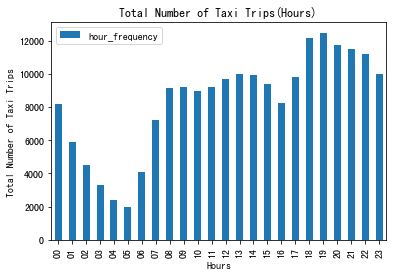

In [49]:
dataframe1 = get_data_for_visual_1()
plot_visual_1(dataframe1)

### Visualization 2

_**TODO 1:** Create a visualization that shows the average distance traveled per month (regardless of year - so group by each month)._

_**TODO 2:** Include the 90% confidence interval around the mean in the visualization._


In [50]:
def plot_visual_2(dataframe):
    """
    Get the average distance traveled per month
    
    Arguments:
    dataframe
    
    Returns:
    None
    
    """
    plot_title = "Average Distance Travelled(Month) With 90% Confidence Interval"
    x_label = "Month"
    y_label = "Average Distance"
    dataframe.plot(kind="bar",x="month", y="mean", yerr = "confidence inverval", title=plot_title, xlabel=x_label, ylabel=y_label)

In [51]:
def get_data_for_visual_2() -> pd.core.frame.DataFrame:
    # Query SQL database for the data needed.
    QUERY_month = """
    WITH hired_trips AS
    (
    SELECT pickup_datetime, distance FROM taxi_trips
    UNION ALL
    SELECT pickup_datetime, distance FROM uber_trips
    )
    
    SELECT strftime("%m", pickup_datetime) month, SUM(distance) as distance_m
          FROM hired_trips
          GROUP BY strftime("%Y-%m", pickup_datetime)
    
    """
    dataframe = pd.read_sql_query(QUERY_month, engine)
    data = dataframe.groupby('month') # splite dataframe into 12 subdataframes by using group by month
    
    m = []
    mean = []
    cl = []
    for x in data.groups:
        month = data.get_group(x)
        se = st.sem(month['distance_m'])
        h = se * st.t.ppf((1 - 0.90) / 2, len(month)-1) # calculate the yerr for each month
        
        m.append(month['month'].iloc[0])
        mean.append(np.mean(month['distance_m']))
        cl.append(abs(h))
    df = pd.DataFrame({'month': m,'mean': mean,'confidence inverval': cl}) # create a new dataframe contains month, average distance, and yerr
    return df

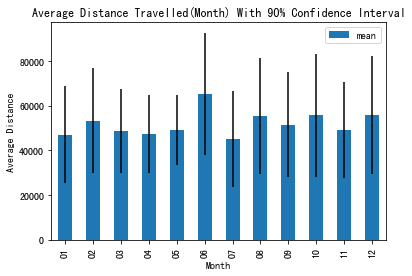

In [52]:
dataframe2 = get_data_for_visual_2()
plot_visual_2(dataframe2)

### Visualization 3

_**TODO 1:** Define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR._

_**TODO 2:** Create a visualization that compares what day of the week was most popular for drop offs for each airport._


In [53]:
def plot_visual_3(dataframe):
    """Plot the most popular day for drop offs for each airport"""
    plot_title = "Number of Trips on Each Day for Each Airport"
    x_label = "Day"
    y_label = "Number of trips for both taxi and uber"
    dataframe.plot(kind="bar",x="day", y=["LGA","JFK","EWR"], title=plot_title, xlabel=x_label, ylabel=y_label)

In [54]:
def get_data_for_visual_3() -> pd.core.frame.DataFrame:
    
    #the coordinae boxes of three New York airports:
    #manually get the estimated value from bboxfinder.com
    LGA_BOX_COORDS = ("LGA", -73.887830, 40.767336, -73.855815, 40.783066)
    JFK_BOX_COORDS = ("JFK", -73.829498, 40.621421, -73.743668, 40.670655)
    EWR_BOX_COORDS = ("EWR", -74.193144, 40.670778, -74.151688, 40.708525)
    
    BOX_COORDS = [LGA_BOX_COORDS, JFK_BOX_COORDS, EWR_BOX_COORDS]
    
    table = []
    for x in BOX_COORDS:
        # Query SQL database for the data needed.
        QUERY = f"""
        WITH hired_trips AS(
        SELECT pickup_datetime AS date, dropoff_longitude, dropoff_latitude
        FROM taxi_trips
    
        UNION ALL
     
        SELECT pickup_datetime AS date, dropoff_longitude, dropoff_latitude
        FROM uber_trips
        )
        
        SELECT strftime("%w", date) AS day, count(*) AS {x[0]} FROM hired_trips
        WHERE dropoff_longitude BETWEEN {x[1]} AND {x[3]}
        AND dropoff_latitude BETWEEN {x[2]} AND {x[4]}
        GROUP BY day
        """
        table.append(pd.read_sql_query(QUERY, engine))
        
    df = pd.merge(pd.merge(table[0],table[1],on='day'),table[2],on='day') # merge three dataframes obtained from sql
    return df

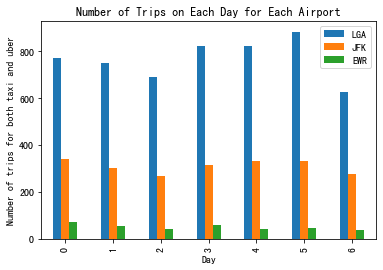

In [55]:
dataframe3 = get_data_for_visual_3()
plot_visual_3(dataframe3)

### Visualization 4

_**TODO:** Create a heatmap of all hired trips over a map of the area._


In [56]:
def plot_visual_4(dataframe):
    """"
    Plot the heatmap of all hired trips over a map of the area.
    
    Arguments:
    dataframe

    """
    taxi_zones = gpd.read_file(filename='taxi_zones.zip', engine='fiona')
    taxi_zones = taxi_zones.to_crs(4326)
    merged = gpd.sjoin(dataframe, taxi_zones[['LocationID','geometry']], how='left', op='within')
    merged.dropna(subset=['LocationID'],inplace=True)
    count = merged.groupby('LocationID')['coords'].count()
    df = pd.merge(taxi_zones, count, on="LocationID")
    
    df.plot(column='coords', cmap='tab20c', legend=True, markersize = 10)
    plt.axis('off')
    plt.title('Heatmap for All Hired Trips')
    plt.show()

In [57]:
def get_data_for_visual_4():
    # Query SQL database for the data needed.
    QUERY = """
    WITH hired_trips AS(
    SELECT pickup_longitude, pickup_latitude
    FROM taxi_trips
    
    UNION ALL
     
    SELECT pickup_longitude, pickup_latitude
    FROM uber_trips
    )
    
    SELECT pickup_longitude, pickup_latitude
    FROM hired_trips
    """
    
    df = pd.read_sql_query(QUERY, engine)
    df.columns = ['longitude', 'latitude']
    df['coords'] = list(zip(df['longitude'],df['latitude']))
    df['coords'] = df['coords'].apply(Point)
    points = gpd.GeoDataFrame(df, geometry='coords')
    return points

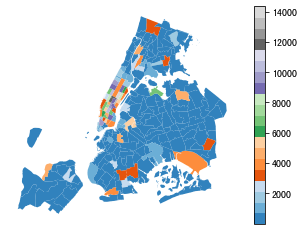

In [58]:
dataframe4 = get_data_for_visual_4()
plot_visual_4(dataframe4)

### Visualization 5

_**TODO:** Create a scatter plot that compares tip amount versus distance._


In [59]:
def plot_visual_5(dataframe):
    """
    Plot the scatter of tip amount versus distance
    
    """
    plot_title = "Tip Amount Versus Distance"
    x_label = "Distance"
    y_label = "Tip Amount"
    dataframe[(dataframe["distance"]>=0) & (dataframe["tip_amount"]>=0)].plot(kind="scatter",x="distance", y="tip_amount", 
                                                                              title=plot_title, xlabel=x_label, ylabel = y_label, 
                                                                              alpha = 0.6, lw=0.01)

In [60]:
def get_data_for_visual_5() -> pd.core.frame.DataFrame:
    """
    Returns:
    dataframe
    
    """
    QUERY_tip_distance = """
    SELECT tip_amount, distance
    FROM taxi_trips
    """
    dataframe = pd.read_sql_query(QUERY_tip_distance, engine)
    return dataframe


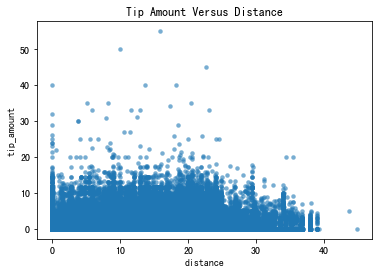

In [61]:
dataframe5 = get_data_for_visual_5()
plot_visual_5(dataframe5)

### Visualization 6

_**TODO:** Create another scatter plot that compares tip amount versus precipitation amount for Yellow Taxi rides._


In [62]:
def plot_visual_6(dataframe):
    """
    Plot the scatter of tip amount versus precipitation amount
    
    """
    plot_title = "Heatmap for All Hired Trips"
    plot_title = "Tip Amount Versus Precipitation"
    x_label = "Precipitation"
    y_label = "Tip Amount"
    # There may exist a confounder between tip amount and precipitation. 
    # For example, when precipitation = 0, it shows a good weather.
    # People may more willing to go outside by uber or taxi, so the number of trips will much larger than that in rainning days, and the total tip amount at sunnyday is large.
    # On the contrary, when precipitation is large, people may not willing to hang out, which may result only a few trips in that days, so the total tip amount at the stormy days is relatively low.
    # Thus, we cannot drop any outliers only based on tips and precipitation.
    dataframe.plot(kind="scatter", x="precipitation", y="tips", title=plot_title, xlabel=x_label, ylabel = y_label, alpha = 0.6, lw=0.01)

In [63]:
def get_data_for_visual_6() -> pd.core.frame.DataFrame:
    """
    Returns:
    dataframe
    
    """
    # Query SQL database for the data needed.
    QUERY = """
    SELECT dw.DATE, SUM(tt.tip_amount) AS tips, dw.DailyPrecipitation AS precipitation
    FROM taxi_trips tt INNER JOIN daily_weather dw
    ON strftime('%Y-%m-%d', tt.pickup_datetime) = dw.DATE
    GROUP BY dw.DATE
    """
    
    df = pd.read_sql_query(QUERY, engine)
    return df

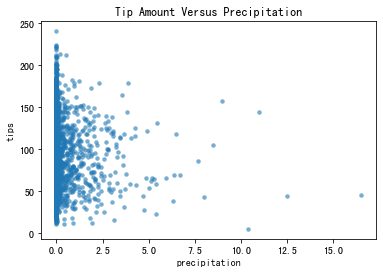

In [64]:
dataframe6 = get_data_for_visual_6()
plot_visual_6(dataframe6)